This script aims to understand what is causing the instability in my RMSE across folds. It is clear that the instability comes from the data, not the chosen model since also very simple models likek Linear Regression yield large instability.
We will therefore analyze the dataset in depth looking for the cause of such instability.

In [1]:
import pandas as pd
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# load the dataset
data = pd.read_csv('../../data/preprocessed/training.csv')

In [3]:
# manually pick the features
manually_picked_features = [
    "value_eur", 'release_clause_eur', 'wage_eur', 'international_reputation', 'overall', 'club_name_te',
    'potential', 'log_wage_eur', 'log_release_clause_eur', 'age', 'position_group_Goalkeeper',
    'position_group_Defender', 'position_group_Midfielder', 'position_group_Attacker', 'height_cm', 'weight_kg',
    'priority',"pace","shooting","passing","dribbling","defending","physic", "goalkeeping_diving"
]

In [4]:
data = data[manually_picked_features]

random_state = 100

1. LEAVE ONE BIN OUT RMSE
This test splits the data based on the value range of the target. Then for every bin, it trains the model on all other bins and tries to predict the left-out bin.
It aims to understand if some value ranges are more difficult to predict (e.g. very high-valued players).
This is done both with standard root MSE, as well as with relative root MSE, where errors are normalized by the mean target of their bin.

Leave-One-Bin-Out Results:
----------------------------------------
Bin 0: RMSE = 221,810, Mean = 253,627, Normalized RMSE = 0.8745, Samples = 3173
Bin 1: RMSE = 139,639, Mean = 573,770, Normalized RMSE = 0.2434, Samples = 3109
Bin 2: RMSE = 217,398, Mean = 1,029,430, Normalized RMSE = 0.2112, Samples = 3194
Bin 3: RMSE = 446,903, Mean = 1,833,817, Normalized RMSE = 0.2437, Samples = 2824
Bin 4: RMSE = 16,629,086, Mean = 10,769,568, Normalized RMSE = 1.5441, Samples = 3033
----------------------------------------


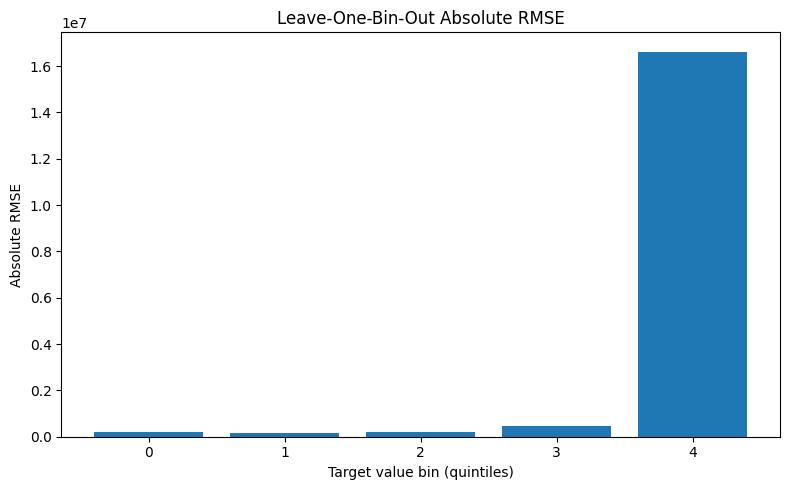

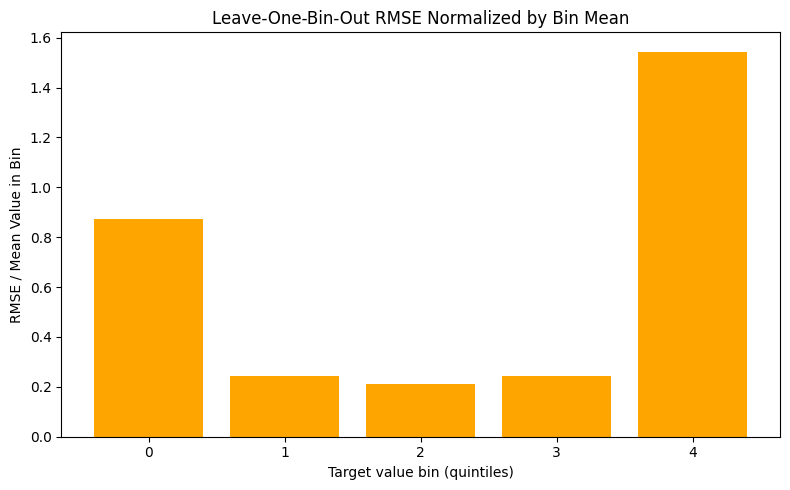

In [5]:
# === Bin the data into quantiles of the target ===
data["bin"] = pd.qcut(data["value_eur"], q=5, labels=False)

# === Define feature columns (exclude target and bin columns) ===
excluded = ["value_eur", "bin"]
features = [col for col in data.columns if col not in excluded]

# === Evaluate RMSE and bin-normalized RMSE ===
abs_errors_by_bin = []
rel_errors_by_bin = []

print("Leave-One-Bin-Out Results:")
print("-" * 40)

for b in sorted(data["bin"].unique()):
    train_subset = data[data["bin"] != b]
    test_subset = data[data["bin"] == b]

    X_train = train_subset[features]
    y_train = train_subset["value_eur"]
    X_test = test_subset[features]
    y_test = test_subset["value_eur"]

    model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=random_state)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Absolute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    abs_errors_by_bin.append((b, rmse, len(test_subset)))

    # Bin-mean-normalized RMSE (relative RMSE)
    bin_mean = y_test.mean()
    rel_rmse = rmse / bin_mean
    rel_errors_by_bin.append((b, rel_rmse, len(test_subset)))

    print(f"Bin {b}: RMSE = {rmse:,.0f}, Mean = {bin_mean:,.0f}, Normalized RMSE = {rel_rmse:.4f}, Samples = {len(test_subset)}")

print("-" * 40)

# === Plot absolute RMSE ===
bins, abs_rmses, _ = zip(*abs_errors_by_bin)
plt.figure(figsize=(8, 5))
plt.bar(bins, abs_rmses)
plt.xticks(bins)
plt.xlabel("Target value bin (quintiles)")
plt.ylabel("Absolute RMSE")
plt.title("Leave-One-Bin-Out Absolute RMSE")
plt.tight_layout()
plt.show()

# === Plot bin-mean-normalized RMSE ===
_, rel_rmses, _ = zip(*rel_errors_by_bin)
plt.figure(figsize=(8, 5))
plt.bar(bins, rel_rmses, color="orange")
plt.xticks(bins)
plt.xlabel("Target value bin (quintiles)")
plt.ylabel("RMSE / Mean Value in Bin")
plt.title("Leave-One-Bin-Out RMSE Normalized by Bin Mean")
plt.tight_layout()
plt.show()

Here we show that if our dataset had only the first 4 bins, even a simple random forest would solve the problem easily, with only ~70k RMSE on 5-fold cross validation.

It is clear that to decrease RMSE one should really focus on improving predictions for the upper outliers.

This, together with the heterogeneity of the regressors' distribution outlined by the autoencoders, motivates our choice to train a separate model for the upper outliers and build a pipeline to ensemble the predictions into a single model.

In [6]:
# === Filter to bins 0–3 only ===
data = data[data["bin"] != 4]
X = data[features]
y = data["value_eur"]
print(f"Training on {len(X)} samples from bins 0–3")

# === Define hyperparameter grid ===
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'max_features': [0.5]
}

# === Define 5-fold cross-validation ===
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

results = []

for params in tqdm(ParameterGrid(param_grid), desc="Random Forest CV Grid Search"):
    fold_rmses = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = RandomForestRegressor(
            n_jobs=-1,
            random_state=random_state,
            bootstrap=True,
            **params
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        fold_rmses.append(rmse)
    
    mean_rmse = np.mean(fold_rmses)
    std_rmse = np.std(fold_rmses)
    results.append((params, mean_rmse, std_rmse))

# === Sort results by average RMSE ===
results.sort(key=lambda x: x[1])

# === Print top models ===
print("\nTop Random Forest Models by 5-Fold CV RMSE:")
for i, (params, mean_rmse, std_rmse) in enumerate(results[:5], 1):
    print(f"\nModel {i}")
    print(f"  Params:           {params}")
    print(f"  Mean CV RMSE:     {mean_rmse:,.2f}")
    print(f"  Std. Dev. RMSE:   {std_rmse:,.2f}")

Training on 12300 samples from bins 0–3


Random Forest CV Grid Search: 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


Top Random Forest Models by 5-Fold CV RMSE:

Model 1
  Params:           {'max_depth': None, 'max_features': 0.5, 'n_estimators': 300}
  Mean CV RMSE:     69,871.61
  Std. Dev. RMSE:   2,892.19
